In [3]:
#@title {vertical-output: true}

#============================================================
#INSTALLS & IMPORTS

!pip install pyreadstat
import pandas as pd
import numpy as np
import pyreadstat
import requests
from collections import defaultdict
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

#============================================================
#VARIABLES

#changeBelowLink
url = "https://github.com/maxwell-petitjean/regression/raw/refs/heads/main/brand_tracking_test.sav"

#Download the file
response = requests.get(url)
with open("brand_tracking_test.sav", "wb") as f:
    f.write(response.content)

#read SPSS file
df, meta = pyreadstat.read_sav("brand_tracking_test.sav")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 80.4 MB/s eta 0:00:00


In [4]:
#check shape
print(df.shape)

(1032, 1476)


In [5]:
#@title {vertical-output: true}
#see cols - vertical
pd.set_option("display.max_rows", None)
print(df.iloc[0])

ResponseID                                     207348029.0
RespondentID                                   229229999.0
Intro_Consent                                          NaN
Intro_Consent_Age                                      NaN
dCountry                                               8.0
Wave                                                   1.0
Gender                                                 2.0
dGender                                                2.0
AGE_1                                                 20.0
dAgeBand                                               1.0
Q1_1                                                   1.0
Q1_2                                                   0.0
Q1_3                                                   1.0
Q1_4                                                   0.0
Q1_5                                                   1.0
Q1_97                                                  0.0
Q1_99                                                  0

In [6]:
#check all columns
pd.set_option("display.max_columns", None)
print( df.head(4) )

    ResponseID  RespondentID  Intro_Consent  Intro_Consent_Age  dCountry  \
0  207348029.0   229229999.0            NaN                NaN       8.0   
1  207348083.0   229230053.0            NaN                NaN       8.0   
2  207348318.0   229230287.0            NaN                NaN       8.0   
3  207348393.0   229230362.0            NaN                NaN       8.0   

   Wave  Gender  dGender  AGE_1  dAgeBand  Q1_1  Q1_2  Q1_3  Q1_4  Q1_5  \
0   1.0     2.0      2.0   20.0       1.0   1.0   0.0   1.0   0.0   1.0   
1   1.0     2.0      2.0   23.0       1.0   1.0   1.0   0.0   1.0   1.0   
2   1.0     1.0      1.0   26.0       2.0   1.0   1.0   1.0   1.0   1.0   
3   1.0     2.0      2.0   30.0       2.0   1.0   0.0   0.0   1.0   1.0   

   Q1_97  Q1_99  Q2_1  Q2_2  Q2_3  Q2_4  Q2_5  Q2_6  Q2_7  Q2_8  Q2_9  Q2_98  \
0    0.0    0.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0   
1    0.0    0.0   1.0   1.0   1.0   0.0   1.0   0.0   1.0   0.0   0.0    0.0   
2  

In [7]:
#tidy up column names
df2 = df.copy()

#rename columns so that we can easily pick columns next
df2 = df2.rename(columns=lambda c: c.replace("BRANDBUYER_", "brand-", 1) if "BRANDBUYER" in c else c)
df2 = df2.rename(columns=lambda c: c.replace("__", "_", 1) if "__" in c else c)
df2 = df2.rename(columns=lambda c: c.replace("ResponseID", "qq_id", 1) if "ResponseID" in c else c)
df2 = df2.rename(columns=lambda c: c.replace("Gender", "qq_gender", 1) if "Gender" in c else c)
df2 = df2.rename(columns=lambda c: c.replace("AGE_1", "qq_age", 1) if "AGE_1" in c else c)
df2 = df2.rename(columns=lambda c: c.replace("dAgeBand", "qq_age_group", 1) if "dAgeBand" in c else c)

#only columns that start with
df2 = df2.loc[:, df2.columns.str.startswith(("Q","qq_","brand"))]

#columns to remove **based on strings i dont know what to do with
remove_strings = ["trans","DK","Other"]
df2 = df2.loc[:, ~df2.columns.str.contains("|".join(remove_strings))]


df3 = df2.copy()


In [9]:
#go have a look at the pre-post cleaning
print("Before:", df.shape)
print("After :", df3.shape)


Before: (1032, 1476)
After : (1032, 1089)


In [13]:
df4 = df3.copy()

#outcome variable
OUTCOME_COL = "Q10_1"
y = df4[OUTCOME_COL].astype(float)


#build predictor
X = df4.drop(columns=[OUTCOME_COL])

#numeric columns only
X = X.select_dtypes(include=["number"])

#drop columns **could add more here
X = X.drop(columns=["qq_id"], errors="ignore")

#clean nulls
X = X.fillna(0)
y = y.fillna(y.mean())

#run ols
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const)
result = model.fit()

print(result.summary())



                            OLS Regression Results                            
Dep. Variable:                     10   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     3.384
Date:                Thu, 18 Dec 2025   Prob (F-statistic):           2.80e-13
Time:                        17:16:57   Log-Likelihood:                -1178.9
No. Observations:                1032   AIC:                             4206.
Df Residuals:                     108   BIC:                             8770.
Df Model:                         923                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
qq_gender               0.1077    

In [14]:
#standardise X and y
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_std = scaler_X.fit_transform(X)
y_std = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

#intercept
X_std_const = sm.add_constant(X_std)

#refit with intercept
std_model = sm.OLS(y_std, X_std_const)
std_result = std_model.fit()

In [23]:
#create standardised beta for features
summary_df = pd.DataFrame({
    "variable": X.columns,
    "coef": result.params[X.columns],
    "std_err": result.bse[X.columns],
    "t_stat": result.tvalues[X.columns],
    "p_value": result.pvalues[X.columns],
    "std_beta": std_result.params[1:]
})

# Add absolute impact for ranking
summary_df["abs_std_beta"] = summary_df["std_beta"].abs()

top20 = (
    summary_df
    .sort_values("abs_std_beta", ascending=False)
    .head(20)
)

#basically which column matters most?
#actual calculation
  #change in each sd unit of outcome column
  #for a 1sd increase in predictor column
top20


,variable,coef,std_err,t_stat,p_value,std_beta,abs_std_beta
Q20_7_14,Q20_7_14,-10.225996,3.078243,-3.322024,0.001220,-3.615636,3.615636
Q20_1_10,Q20_1_10,3.944096,1.390830,2.835786,0.005459,2.893405,2.893405
Q20_7_2,Q20_7_2,-1.146751,3.291823,-0.348364,0.728245,2.792367,2.792367
Q20_1_9,Q20_1_9,-3.571896,1.392649,-2.564821,0.011696,-2.621003,2.621003
Q12_7,Q12_7,-1.744366,1.908173,-0.914155,0.362672,-2.386300,2.386300
Q20_7_6,Q20_7_6,-7.796438,2.722364,-2.863848,0.005029,-2.071886,2.071886
Q14_9_10,Q14_9_10,48.572436,20.980800,2.315090,0.022498,1.799915,1.799915
Q6_10,Q6_10,-10.889129,8.722693,-1.248368,0.214596,-1.791315,1.791315
Q20_7_12,Q20_7_12,-12.738681,4.095663,-3.110285,0.002391,-1.759271,1.759271
Q14_15_10,Q14_15_10,-30.854868,22.277672,-1.385013,0.168903,-1.290002,1.290002


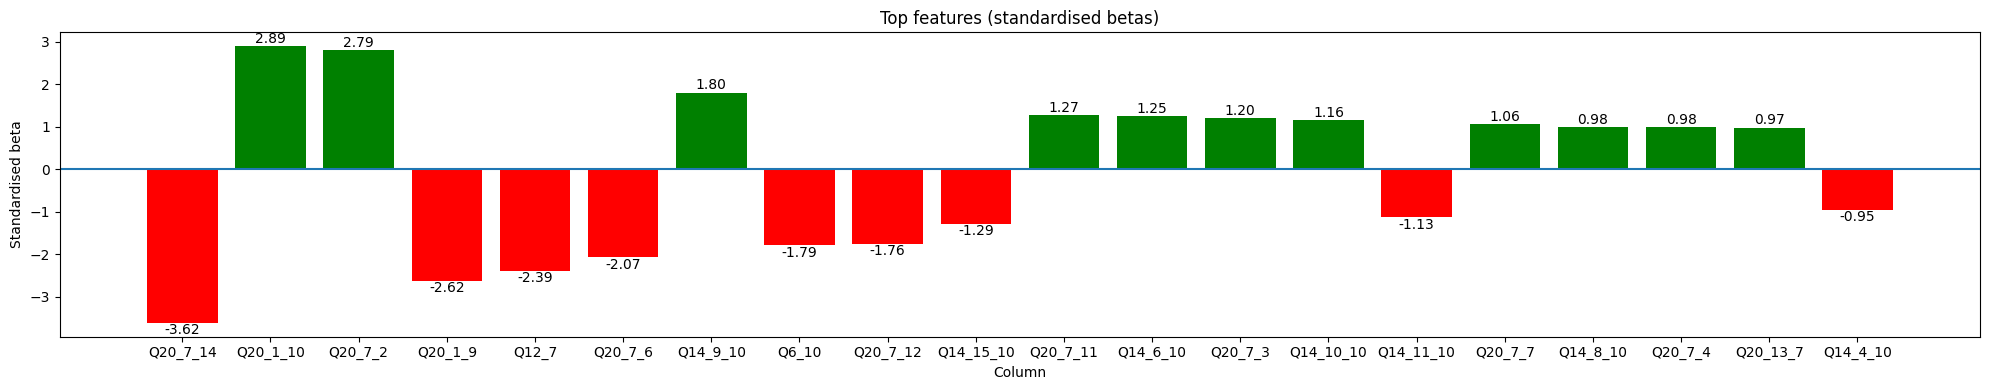

In [42]:
# top feature bar chart vis
TOP_N = 20
top_feature = summary_df.sort_values("abs_std_beta", ascending=False).head(TOP_N)

# Colour by sign
colors = ["green" if b > 0 else "red" for b in top_feature["std_beta"]]

# Plot
plt.figure(figsize=(20,4))
bars = plt.bar(
    top_feature["variable"],
    top_feature["std_beta"],
    color=colors
)

# Zero line
plt.axhline(0)

# Add data labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + (0.01 if height > 0 else -0.01),
        f"{height:.2f}",
        ha="center",
        va="bottom" if height > 0 else "top",
        fontsize=10
    )

plt.title("Top features (standardised betas)")
plt.xlabel("Column")
plt.ylabel("Standardised beta")

plt.tight_layout()
plt.show()
